In [1]:
%matplotlib inline

# Classifying Cats vs. Dogs using Transfer Learning

Suppose you have a problem that you want to solve using a deep learning algorithm, but want to reuse the models that were developed before.
For the sake of an example, let's say you want to classify if it's an image of a dog or a cat.
There is no ready model that can do it for you, so you might use this writeup to help you out.

## Setup

The first step is to tell the system where the data is stored.
For this example, you need to download the data from http://www.zbrain.io/datasets/dogs-vs-cats.zip, and unzip it to `dogs-vs-cats` directory.
Although you can run the training on the whole dataset, it might be too time consuming.
Instead, you can run the `make_reduced_dataset.py` to create a smaller dataset.

```shell
mkdir reduced
python make_reduced_dataset.py train reduced
```

**Note**: If you are not using the reduced dataset, change the variables in the next cell accordingly.

In [2]:
# Get the data location

import os
import sys
hostname = !hostname

if hostname[0] == 'z-deepbox':
    DATA_PATH = os.path.join(os.path.expanduser('~'), 'data')
else:
    # TODO: Download and unzip the data here
    DATA_PATH = 'data'
CATS_DOGS_PATH = os.path.join(DATA_PATH, 'dogs-vs-cats', 'reduced')

In [3]:
import torch
DEVICE = torch.device('cuda' if torch.cuda.is_available else 'cpu')

### Getting the training scripts

In this example, you don't need to write the trainng loops -- this part is written for you.
You can get the instructions on how to use the training scripts here: https://github.com/z-a-f/torchscripts/blob/master/README.md

In [4]:
# Add the training scripts location
if hostname[0] == 'z-deepbox':
    TRAINER_PATH = os.path.join(os.path.expanduser('~'), 'Git', 'torchscripts')
else:
    TRAINER_PATH = 'torchscripts'
    !git clone https://github.com/z-a-f/torchscripts torchscripts
sys.path.append(TRAINER_PATH)

### Setting up a Model for Transfer Learning

There are three sets of data in the "reduced" dataset:

- `train` is used to train the neural network
- `validation` is used to check the performance of the neural network during the training phase
- `test` is the dataset to report the final results

The reason you require a split in the data is because you need to monitor the progress of the training process.
However, it is not advised to use the training data to make decisions to make improvements in the network -- this might cause a bias towards that particular dataset.
Instead you monitor the performance of the validation data.

The test set is completely independent of the design-time improvements, and hence could be used to report the final finding with a very little chance of bias.

![Data Split](img/data_split.png)

There are several different strategies how to split the data.
The simplest is to split it with ratios 0.5, 0.3, 0.2 (or something similar).
Although in this exercise you don't need to run the epochs loop, if you decide to, you will need to rerun the training/evaluation step at every epoch for the training and validation sets (shown above).

In [5]:
# Create the data paths for every running mode
if CATS_DOGS_PATH.split('/')[-1] == 'reduced':
    modes = ['train', 'validation', 'test']
else:
    modes = ['train']  # validation and test don't exist in non-reduced mode
data_paths = {}
for mode in modes:
    data_paths[mode] = os.path.join(CATS_DOGS_PATH, mode)

## Creating a Model Based on an Existing One

Creating a model is a fairly involved process.
However, if you have a model that was already trained for some similar dataset, you can reuse it.
This process is called **transfer learning** -- you transfer an existing pre-trained model with minimal changes.

The drawing below shows different ways how you can adopt a model to your application.
The top one shows the original model, which has a pre-trained feature extractor (FE) and a pre-trained head (head is the part that does the inference).

![Transfer Learning Models](img/transfer_learning_model_split.png)

Here is the description of the model transfer as shown in the image above

0. **Original model**
1. **Add/Replace more layers to the head**.
    Train the added part, while keeping the original model unchanged (frozen).
    _**When to use:**_ If an existing model is pre-trained to a very similar dataset, and you need to change the number of classes or just add slighly different classes.
2. **Add/Replace more layers to the head**.
    Train the added part, while fine-tuning the existing head.
    Keep the feature extractor frozen.
    _**When to use:**_ When the new data that you are trying to adapt to is very different from the one it was pretrained to.
3. **Completely replace the head, but not the feature extractor**. _**When to use:**_ If you are trying to train to a completely new dataset, and the only thing in common with the "pre-trianing dataset" is its nature. For example, training to to learn how to drive based on camera inputs, while the model is trained for generic images.
4. **Replace (or modify) and retrain the head, while fine-tuning the feature extrctor**. _**When to use:**_ Mostly same as in the previous example.

In this exercise you will be going with option 1 -- add more layers to an existing model.
Read the comments in the next cell to learn how to do it.
The pretrained model that you will be using can be found here: https://pytorch.org/hub/pytorch_vision_mobilenet_v2/. ALso take note of any transformations used for this model (described below).

In [6]:
# Create a model with MobileNet-v2 backbone

from torch import nn
from torchvision import models

# Backbone model -- the pretrained model that will be used.
# Backbone includes both the pretrained feature extractor and the head.
backbone_model = models.mobilenet_v2(pretrained=True, progress=True)
# To freeze the model you need to set `requires_grad = False` for all the parameters
for param in backbone_model.parameters():
    param.requires_grad = False

# This is a new head model
new_head_model = nn.Linear(1000, 2)

# Add the new head to an existing model
model = nn.Sequential(
    backbone_model,
    new_head_model
)
model = model.to(DEVICE)  # Sends the model to either CPU or CUDA

## Adding transformations to the data

Before using the data, you must follow some basic transformation steps.
The most obvious one is converting from **image** to **tensor**.
Another transformation is that you often need to have the inputs of a specific shape.
For the `MobileNetv2` that we use the expected shape is $224x224$ pixels.
Also, the inputs must be normalized -- in this example to `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]` (as described in https://pytorch.org/hub/pytorch_vision_mobilenet_v2/)

In [7]:
# Create the transforms
import numpy as np
import PIL
from torchvision import transforms as T

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Add transformations
transforms = {
    'train':
        T.Compose([
            T.Resize(256, interpolation=PIL.Image.BILINEAR),
            T.RandomCrop((224, 224)),  # Add a little randomness to the training data
            T.ToTensor(),
            T.Normalize(mean=mean, std=std),
        ]),
    'validation':
        T.Compose([
            T.Resize(256, interpolation=PIL.Image.BILINEAR),
            T.CenterCrop((224, 224)),
            T.ToTensor(),
            T.Normalize(mean=mean, std=std),
        ]),
    'test':
        T.Compose([
            T.Resize(256, interpolation=PIL.Image.BILINEAR),
            T.CenterCrop((224, 224)),
            T.ToTensor(),  # Converts HWC to CHW
            T.Normalize(mean=mean, std=std),
        ]),
}

# This is a utility function that converts a tensor back to an image.
def TensorToImage(tensor, mean, std):
    """Converts a tensor back to the image representation"""
    img = tensor.detach().cpu().numpy()
    img = img.transpose(1, 2, 0)
    img = img * std
    img = img + mean
    img = img * 255
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img

PyTorch has a lot of helpful utilities.
One of them is the `torch.utils.data.Dataset` that acts as a "wrapper" around the datasets and transformations.
One particular example of the Dataset is the `torchvision.datasets.ImageFolder`, which is a Dataset created from images stored in a set of folders, with images of a specific class being in the same folder.
To create an `ImageFolder` dataset:

In [8]:
from torchvision import datasets
# Create the dataset
cats_dogs_ds = {
    mode: datasets.ImageFolder(data_paths[mode], transform=transforms[mode])
    for mode in modes
}

Let us see some of the examples

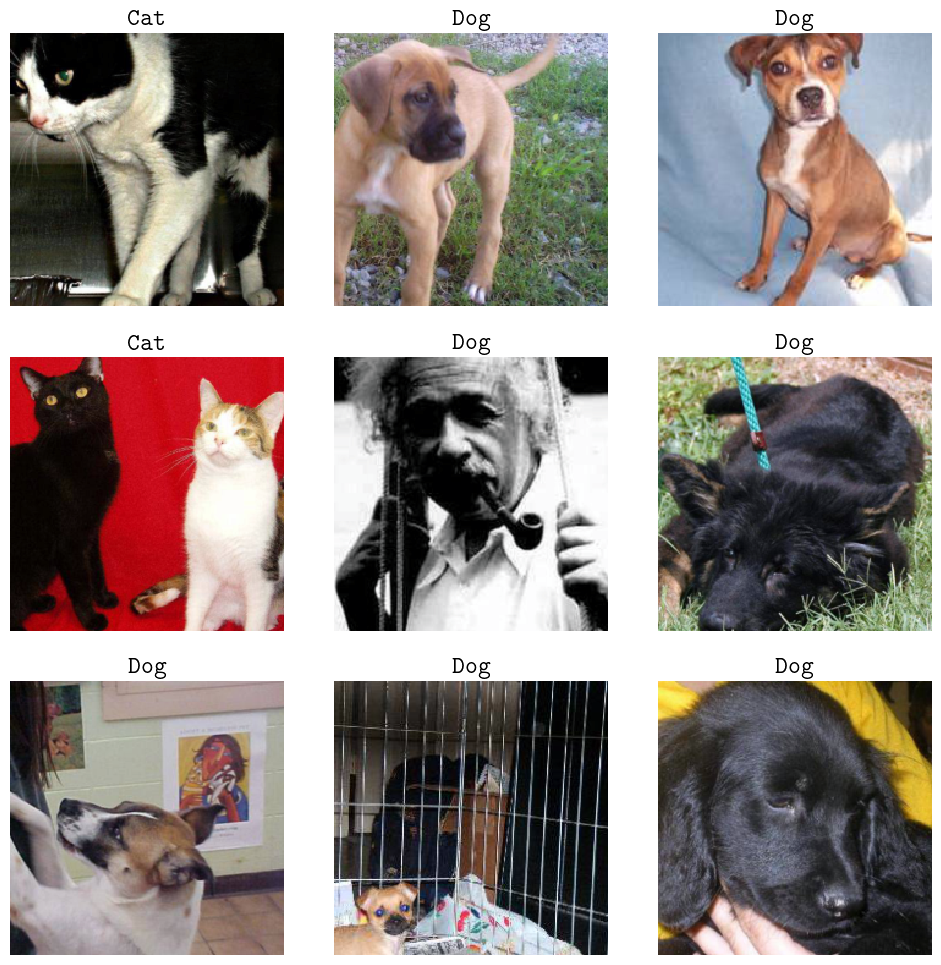

In [9]:
import matplotlib.pyplot as plt

# Show an example
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10, 10))
for a in ax.flat:
    idx = np.random.randint(len(cats_dogs_ds['train']))
    img, lbl = cats_dogs_ds['train'][idx]
    img = TensorToImage(img, mean, std)
    lbl = cats_dogs_ds['train'].classes[lbl]
    
    a.imshow(img)
    a.set_title(lbl)
    a.grid(False)
    a.axis('off')
    
plt.tight_layout()

`torch.utils.data.DataLoader` is another useful utility.
It takes an instance of a `torch.utils.data.Dataset` and acts as an [iterator](https://wiki.python.org/moin/Iterator).
The advantage of using the dataloaders is that you can split the data into batches and use multiprocessing to transform the data.

In [10]:
# Create the dataloaders
from torch.utils.data import DataLoader

BATCH_SIZE = 512
CPU_NUM = os.cpu_count()

dataloaders = { mode: DataLoader(cats_dogs_ds[mode],
                                 shuffle=True,
                                 batch_size=BATCH_SIZE,
                                 num_workers=CPU_NUM,
                                 pin_memory=True) 
                  for mode in modes }

## Setting up an Optimizer

Another piece that needs to be setup before starting the training process, you need to setup an optimizer.
There is a collection of the optimizers in the PyTorch library.
Below is a comparison of different optimizers by [Alec Radford](https://twitter.com/alecrad) (referenced from [Ruder's](https://ruder.io/optimizing-gradient-descent/) blog).


|||
|-|-|
|![](https://ruder.io/content/images/2016/09/contours_evaluation_optimizers.gif)|![](https://ruder.io/content/images/2016/09/saddle_point_evaluation_optimizers.gif)|

In this example you will be using [AdaGrad](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#AdaGrad).

In addition to the optimizer you need to specify the loss function.
Below is the table that shows what optimiters and loss functions work well together.

| Problem                                 | Last Layer Activation | Loss Function                   |
|:----------------------------------------|:----------------------|:--------------------------------|
| Binary Classification                   | Sigmoid               | `CrossEntropyLoss`              |
| Multiclass, Single-Label Classification | Softmax               | `CrossEntropyLoss`              |
| Multiclass, Multi-Label Classification  | Sigmoid               | `CrossEntropyLoss`              |
| Regression                              | **None**              | `MSELoss`                       |
| Regression between 0 and 1              | Sigmoid               | `MSELoss` or `CrossEntropyLoss` |

In [11]:
# Create the optimizer and the loss function
from torch import optim
optimizer = optim.Adagrad(model.parameters(), lr=0.001)

The training routine that you downloaded earlier from https://github.com/z-a-f/torchscripts has the training scripts.
You can read more about the API on GitHub, but the gist is that you can run the training procedure by just creating the `trainer`, and running the `fit` method:

In [12]:
from torchscripts import ClassificationTrainer, classification_metric

trainer = ClassificationTrainer(model, optimizer)
history = trainer.fit(dataloaders['train'], dataloaders['validation'])

1/10
	Train Loss: 0.8549042109489441, Metric: 0.6016
	Valid Loss: 0.41741329259872434, Metric: 0.8216
2/10
	Train Loss: 0.3662636648178101, Metric: 0.8428
	Valid Loss: 0.28253016238212586, Metric: 0.8736
3/10
	Train Loss: 0.2823897415161133, Metric: 0.8824
	Valid Loss: 0.24089494986534118, Metric: 0.8944
4/10
	Train Loss: 0.2338534281015396, Metric: 0.9048
	Valid Loss: 0.21120084290504457, Metric: 0.904
5/10
	Train Loss: 0.21242258353233337, Metric: 0.9112
	Valid Loss: 0.19234380226135253, Metric: 0.9104
6/10
	Train Loss: 0.17964149601459503, Metric: 0.932
	Valid Loss: 0.18031417887210846, Metric: 0.9152
7/10
	Train Loss: 0.17306886100769042, Metric: 0.932
	Valid Loss: 0.1693039121866226, Metric: 0.9232
8/10
	Train Loss: 0.15815975151062012, Metric: 0.9364
	Valid Loss: 0.15993240253925323, Metric: 0.9312
9/10
	Train Loss: 0.15692074205875398, Metric: 0.9368
	Valid Loss: 0.15125618584156036, Metric: 0.9352
10/10
	Train Loss: 0.1435538636445999, Metric: 0.9428
	Valid Loss: 0.144282482552

`history` that was returned has the performance information from every epoch.
Below is the visualization of the training procedure.

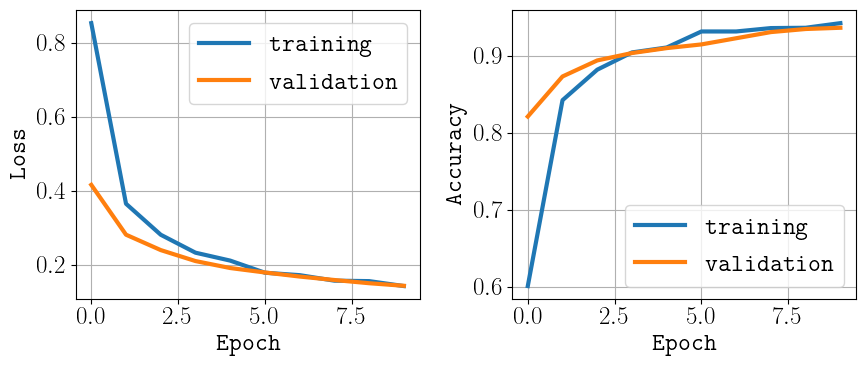

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

epochs = history['epoch']
ax[0].plot(epochs, history['train']['loss'], label='training')
ax[0].plot(epochs, history['validation']['loss'], label='validation')
ax[0].set_ylabel('Loss')

ax[1].plot(epochs, history['train']['metric'], label='training')
ax[1].plot(epochs, history['validation']['metric'], label='validation')
ax[1].set_ylabel('Accuracy')

for a in ax.flat:
    a.legend()
    a.grid()
    a.set_xlabel('Epoch')

plt.tight_layout()

In [14]:
# This is the final accuracy of the enw classifier.
test_predictions, test_loss, test_accuracy = trainer.predict(dataloaders['test'])
print(f'Test accuracy is {test_accuracy:.2%}')

Test accuracy is 95.20%


Here is an example with the confidence levels

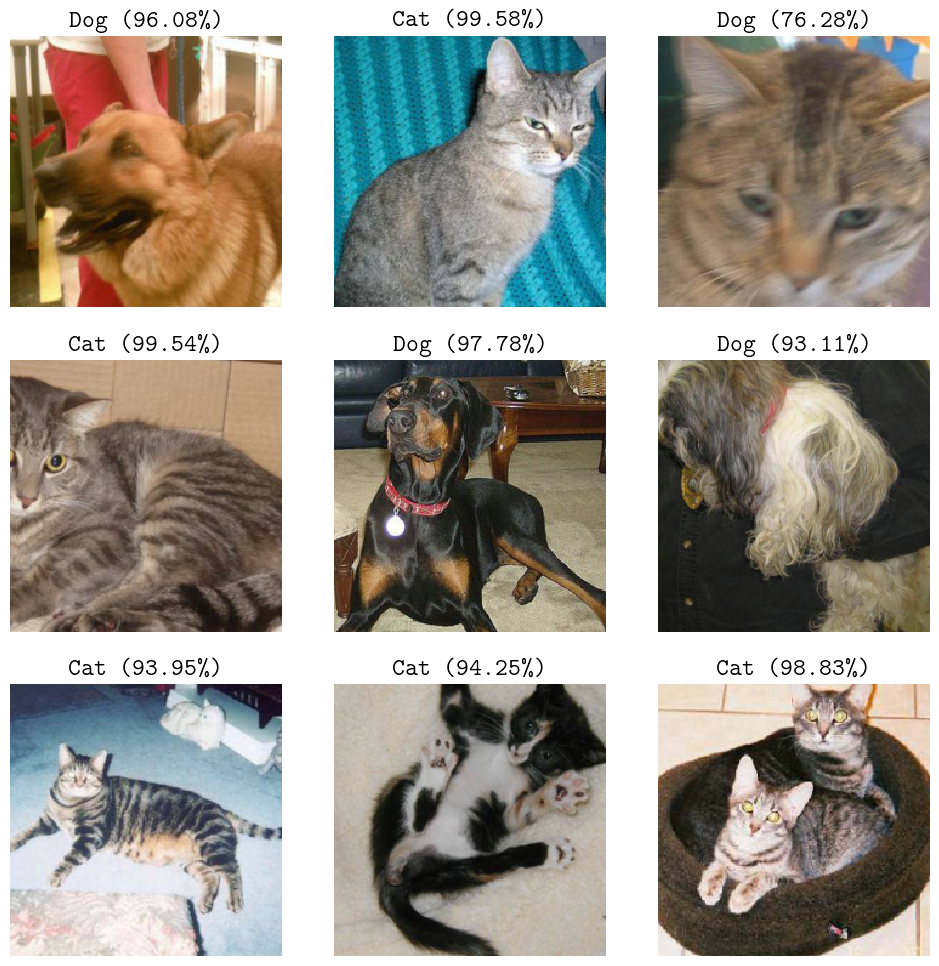

In [15]:
import torch.nn.functional as F

fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10, 10))
for a in ax.flat:
    idx = np.random.randint(len(cats_dogs_ds['test']))
    img, _ = cats_dogs_ds['test'][idx]
    img = torch.unsqueeze(img, 0).to(DEVICE)

    (prediction, probability), _, _ = trainer.predict(img)
    lbl = cats_dogs_ds['test'].classes[prediction.item()]
    
    img = TensorToImage(img[0], mean, std)
    a.imshow(img)
    title = f'{lbl} ({probability.item():.2%})'.replace('%', '\%')
    a.set_title(title)
    a.grid(False)
    a.axis('off')
    
plt.tight_layout()

## Conclusion

If you have a problem that you want to solve using a machine learning algorithm, you can still reuse the models that were pre-created.
Transfer Learning is one way of doing it.
There are a lot of PyTorch models, and in the next post we will make a list of some of the most popular ones and where you could apply them.